In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
from torchvision.io import read_image
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2
import time
from tqdm.notebook import trange, tqdm

### VGG 16 architecture

In [3]:
class VGG16(nn.Module):
    def __init__(self, num_classes = 1000):
        super().__init__()
        # input size => output size
        self.layers = nn.Sequential(
            # 3,300,300 => 64,300,300
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            # 64,300,300 => 64,300,300
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            # 64,300,300 => 64,150,150
            nn.MaxPool2d(kernel_size=2, stride=2),
            # 64,150,150 => 128,150,150
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            # 128,150,150 => 128,150,150
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            # 128,150,150 => 128,75,75
            nn.MaxPool2d(kernel_size=2, stride=2),
            # 128,75,75 => 256,75,75
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(),
            # 256,75,75 => 256,75,75
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(),
            # 256,75,75 => 256,75,75
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(),
            # 256,75,75 => 256,38,38
            nn.AdaptiveMaxPool2d(output_size=38),

            # nn.MaxPool2d(kernel_size=2, stride=2),
            # 256,38,38 => 512,38,38
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
            nn.ReLU(),
            # 512,38,38 => 512,38,38
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.ReLU(),
            # 512,38,38 => 512,38,38
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.ReLU(),
            # 512,38,38 => 512,19,19
            nn.MaxPool2d(kernel_size=2, stride=2),
            # 512,38,38 => 512,10,10
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.ReLU(),
            # 512,10,10 => 512,10,10
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.ReLU(),
            # 512,10,10 => 512,10,10
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.ReLU(),
            # 512,10,10 => 512,10,10
            nn.MaxPool2d(kernel_size=2, stride=2)
            )

        self.fc = nn.Sequential(nn.Linear(512*9*9, 4096), nn.ReLU(), nn.Linear(4096, 4096), nn.Linear(4096, num_classes))


    def forward(self, x):
        convolved = self.layers(x)
        bs,_,h,w = convolved.shape
        convolved = convolved.view(bs, -1)
        return self.fc(convolved)


### Things to know aboubt size/shape of the image

In [4]:
# Normally image read as (Height, Width, Channels) in cv2, plt & PIL
# plt.imread("D:/Learning/ImageClassification/id_cards/2.jpg").shape
# Output: (181, 278, 3)
# In torch, it is read as (Channels, Height, Width) - channels in the first dimension
# Output: (3, 181, 278)

In [5]:
plt.imread("/content/drive/MyDrive/Colab Notebooks/dataset/ImageClassification/train/id_cards/2.jpg").shape

(181, 278, 3)

In [6]:
read_image("/content/drive/MyDrive/Colab Notebooks/dataset/ImageClassification/train/id_cards/2.jpg").shape

torch.Size([3, 181, 278])

### Transform input image to the network

In [7]:
# a simple transformation without any augmentation
# adding augmentation techniques like Horizontal flip, vertical flip, random crop, random rotation, color jtter give better robustness of the model
transforms = T.Compose([T.Resize(size= (300,300)),
                       T.ToTensor()])

In [8]:
transforms

Compose(
    Resize(size=(300, 300), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)

### Dataset for classification

In [26]:
ds = ImageFolder("/content/drive/MyDrive/Colab Notebooks/dataset/ImageClassification/train/",
                transform = transforms)

In [27]:
ds

Dataset ImageFolder
    Number of datapoints: 180
    Root location: /content/drive/MyDrive/Colab Notebooks/dataset/ImageClassification/train/
    StandardTransform
Transform: Compose(
               Resize(size=(300, 300), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )

In [11]:
ds.classes

['id_cards', 'license_plate']

In [12]:
num_classes = len(ds.classes)
num_classes

2

### VGG network creation

In [45]:
vgg = VGG16(num_classes)

In [46]:
device='cpu'
if torch.cuda.is_available():
    device = 'cuda'
device

'cuda'

In [47]:
vgg = vgg.to(device)

In [35]:
!nvidia-smi

Tue Oct 15 06:42:18 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P0              29W /  70W |   6137MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

### Create dataloader

In [48]:
dataloader = DataLoader(ds, batch_size=8, shuffle=True)

### Loss function & optimizer setup

In [49]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg.parameters(), lr = 1.,momentum=0.9, weight_decay=0.9)

### Training loop

In [50]:
EPOCHS = 20

In [51]:
etl = trange(EPOCHS)
for epoch in etl:
    epoch_trn_losses = []
    t = tqdm(dataloader, total = len(dataloader))
    for xb, yb in t:
        xb = xb.to(device)
        yb = yb.to(device)
        logits = vgg(xb)
        loss = loss_fn(logits, yb)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        t.set_postfix(loss = loss.item())

    epoch_trn_losses.append(loss.item())
    epoch_trn_loss = np.array(epoch_trn_losses).mean()
    etl.set_postfix(epoch_loss = epoch_trn_loss)

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

### Save trained weights

In [29]:
torch.save(vgg.state_dict(), "/content/drive/MyDrive/Colab Notebooks/models/vgg16-classification.pt")

### Testing

In [52]:
vgg.eval()

VGG16(
  (layers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU()
    (16): AdaptiveMaxPool2d(output_size=38)
    (17): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (18): ReLU()
    (19): C

In [53]:
ds.classes

['id_cards', 'license_plate']

In [54]:
test_img_path = "/content/drive/MyDrive/Colab Notebooks/dataset/ImageClassification/test/license_plate/100.jpg"

In [55]:
img = Image.open(test_img_path)

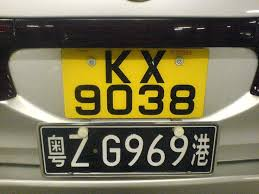

In [60]:
img

In [56]:
x_test = transforms(img).unsqueeze(0).to(device)

In [57]:
with torch.no_grad():
    logits = vgg(x_test)

In [58]:
logits

tensor([[-0.0487,  0.0487]], device='cuda:0')

In [61]:
scores = torch.softmax(logits, dim=-1)
scores

tensor([[0.4757, 0.5243]], device='cuda:0')

In [65]:
labels = scores.argmax(-1)

In [67]:
ds.classes[labels.tolist()[0]]

'license_plate'

In [ ]:
### Model training & testing metrics may not be good, because model finetuned with very few images & transfer learning not employed.